# (sqrt) **XGBoost** 

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Philippines', 'Country_Estonia', 'Country_Andorra', 'Country_El Salvador', 'Country_United Arab Emirates', 'Country_Georgia', 'Country_Tanzania', 'Country_Jordan', 'Country_Venezuela', 'Country_Angola', 'Country_Malta', 'Country_Croatia', 'Country_Uzbekistan', 'Country_Yemen', 'Country_Latvia', 'Ethnicity_North American / Central American', 'Country_Kenya', 'Country_Lebanon', 'Country_Viet Nam', 'Country_Cyprus', 'Country_Saudi Arabia', 'Country_Bangladesh', 'Country_Nomadic', 'Country_Serbia', 'Country_Azerbaijan', 'Country_Botswana', 'Country_Zimbabwe', 'Country_Armenia', 'Country_Costa Rica', 'Country_Peru', 'Country_Sri Lanka', 'Country_Bosnia-Herz.', 'Country_Mongolia', 'Country_New Zealand', 'Country_Slovakia', 'Country_North Macedonia', 'Country_Kosovo', 'Country_Paraguay'}
Columns in the test set that aren't in the train set: {"Country_CÃ´te d'Ivoire", 'Country_Belarus', 'Country_Barbados', 'Country_Republic of Kor

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
baseline_train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
baseline_test_df.drop(538, inplace=True)

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,12.2,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2248, 92)
(2248,)

(552, 92)
(552,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
#y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importance
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [8]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(100, 1000),
    "learning_rate": uniform(0.01, 0.1),
    "max_depth": randint(1, 4),
    "min_child_weight": randint(3, 5),
    "gamma": uniform(0, 2),
    "subsample": uniform(0.4, 0.6),
    "colsample_bytree": uniform(0.4, 0.6),

# {'colsample_bytree': 0.9159642440417923, 'gamma': 1.3606150771755594, 'learning_rate': 0.046049925196954306, 
#  'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 700, 'subsample': 0.9793792198447356}	
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.2s
[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.3s
[CV] END colsample_bytree=0.6247240713084175, gamma=1.9014286128198323, learning_rate=0.0831993941811405, max_depth=1, min_child_weight=3, n_estimators=714, subsample=0.6674996517121548; total time=   1.3s
[CV] END colsample_bytree=0.45998494949080176, gamma=0.9184977839317343, learning_rate=0.04337086111390219, max_depth=3, min_child_weight=4, n_estimators=408, subsample=0.9819459112971965; total time=   1.3s
[CV] END colsample_bytree=0.45998494949080176, gamma=0.9184977839317343, learning_rate=0.04337086111390219, max_depth=3, min_child_weight=4, n_estimators=408, subsample=0.981

#### 3.1.1. CV results

Let's look at results per parameter combination

In [9]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.651058,0.621595,29701.311045,30881.656902
1,0.687680,0.624537,28099.963788,30758.090472
2,0.587931,0.577483,32276.520035,32631.743691
3,0.723873,0.626523,26420.999310,30679.063711
4,0.785964,0.615392,23261.828938,31141.944316
5,0.684667,0.627236,28234.195753,30649.579389
6,0.671882,0.617045,28801.078179,31065.408421
7,0.675231,0.622275,28654.026672,30850.245771
8,0.717515,0.627245,26723.946280,30650.286482
9,0.758971,0.619423,24685.442818,30973.482191


Now, the average of folds:

In [10]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.6944770924644075
Mean CV Train RMSE: 27685.93128194265
--------------------
Mean CV Test R2: 0.617875383084114
Mean CV Test RMSE: 31028.15013464039


In [11]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = pd.DataFrame([{
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }])
        results_df = pd.concat([results_df, fold_results], ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
print(results_df.to_markdown())

|   Fold |   train_r2 |   test_r2 |   train_rmse |   test_rmse |
|-------:|-----------:|----------:|-------------:|------------:|
|      1 |   0.649167 |  0.615372 |      29712.7 |     31326.9 |
|      2 |   0.688864 |  0.623191 |      27981.2 |     31006.8 |
|      3 |   0.585642 |  0.565155 |      32290.9 |     33309.2 |
|      4 |   0.724986 |  0.627372 |      26306.9 |     30834.3 |
|      5 |   0.784249 |  0.609848 |      23300.7 |     31551   |
|      6 |   0.684459 |  0.626327 |      28178.7 |     30877.5 |
|      7 |   0.670874 |  0.611922 |      28778.8 |     31467.1 |
|      8 |   0.673419 |  0.614973 |      28667.4 |     31343.1 |
|      9 |   0.716532 |  0.628255 |      26708.2 |     30797.8 |
|     10 |   0.75713  |  0.616721 |      24721.7 |     31271.9 |
|     11 |   0.644988 |  0.641228 |      29751.2 |     30759.7 |
|     12 |   0.682988 |  0.643879 |      28113.8 |     30645.9 |
|     13 |   0.581308 |  0.603863 |      32309.4 |     32321.8 |
|     14 |   0.719072 |  

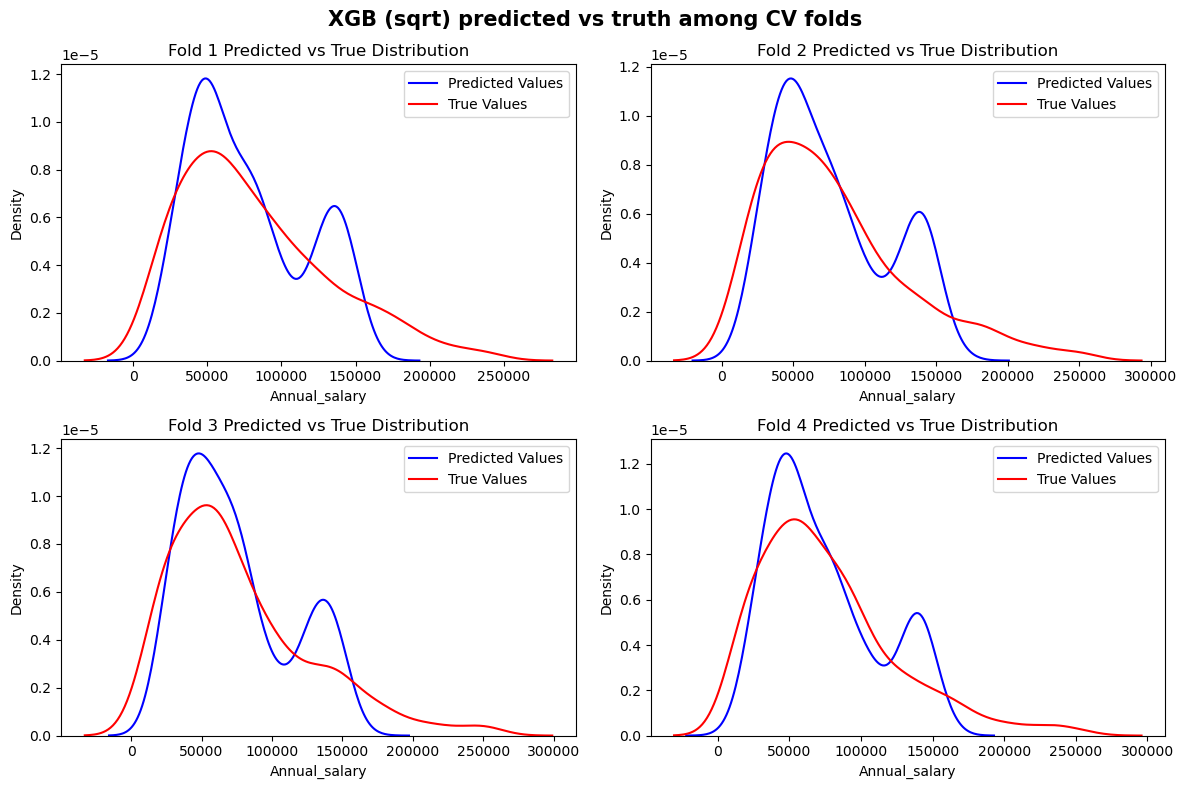

In [12]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('XGB (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [13]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train/Test set results


Train set metrics:
R^2: 0.6767516420494456
RMSE: 28593.28748488229
Adjusted R^2: 0.6629517121508605


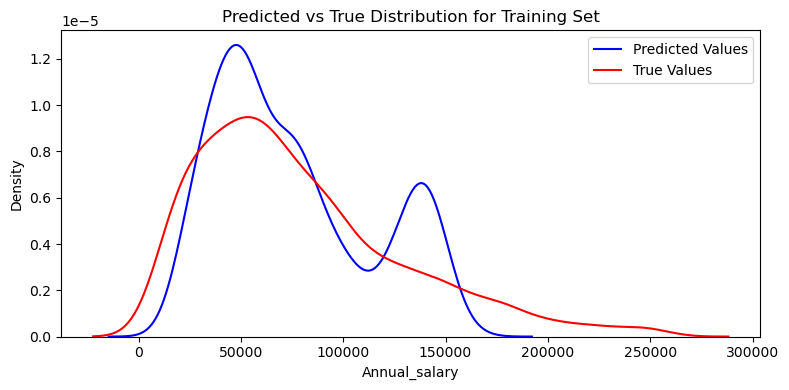

In [14]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6436237355066183
RMSE: 29571.42178213497
Adjusted R^2: 0.5721931988325636


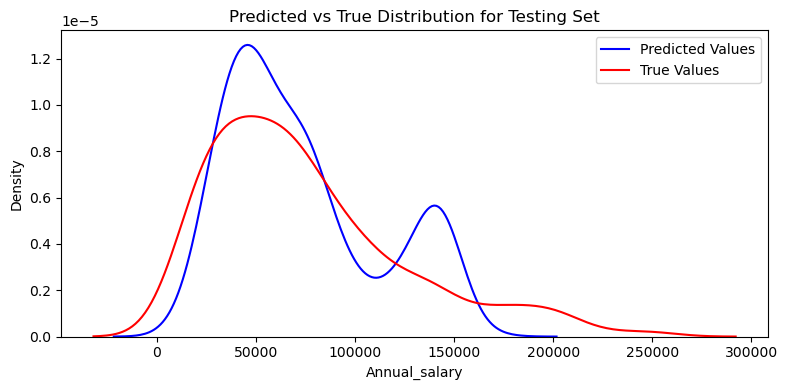

In [15]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

In [17]:
# sns.set_theme(style='darkgrid')

# residuals = np.power(y_test, 2) - y_pred_test

# plt.figure(figsize=(10,5))

# sns.residplot(x=np.power(y_test, 2), y=residuals,robust=False, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

# plt.title('(sqrt) XGB Residuals', weight='bold', fontsize=20, pad=10)
# plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
# # plt.ylim(40000,)
# # plt.xlim(25000,500000)
# plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
# plt.axhline(y=0, color='black', linestyle='--')
# plt.savefig("../../paper/models/sqrt-xgb-test-residuals.pdf");

In [18]:
test_df.Country_USA

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
548    0.0
549    0.0
550    0.0
551    0.0
552    0.0
Name: Country_USA, Length: 553, dtype: float64

In [19]:
test_df.filter(like='Country_').sum().sort_values(ascending=False).head(5)

Country_USA                      132.0
Country_Germany                   56.0
Country_UK & Northern Ireland     41.0
Country_France                    29.0
Country_India                     22.0
dtype: float64

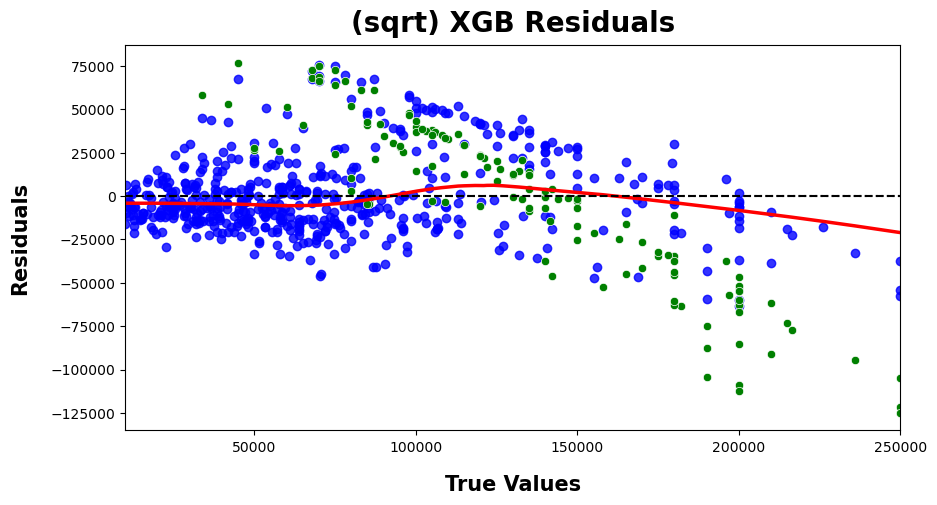

In [26]:
plt.figure(figsize=(10,5))

residuals = y_pred_test  -np.power(y_test, 2) 

# Scatterplot general con todos los puntos en azul
sns.residplot(x=np.power(y_test, 2), y=residuals, robust=False, lowess=True, scatter_kws={'color': 'blue'}, line_kws={'color': 'red', 'lw': 2.5})

# Filtrar puntos correspondientes a Country_USA == 1 y trazarlos en rojo
custom = test_df[test_df['Country_USA'] == 1].index
# custom = residuals[residuals<-40000].index

sns.scatterplot(x=np.power(y_test.loc[custom], 2), y=residuals.loc[custom], color='green')


plt.title('(sqrt) XGB Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-xgb-test-residuals.pdf")
plt.show()


In [21]:
df_comparison

NameError: name 'df_comparison' is not defined

In [ ]:
from yellowbrick.regressor import ResidualsPlot



In [24]:
import pandas as pd

# Crear un DataFrame con las columnas 'Actual' y 'Predicted'
df_comparison = pd.DataFrame({
    'Actual': np.power(y_test, 2),  # Valores actuales al cuadrado
    'Predicted': y_pred_test,
    'Residuals': np.power(y_test, 2)-y_pred_test  # Valores predichos al cuadrado
})

# Imprimir las primeras filas del DataFrame para verificar
print(df_comparison.head())


     Actual      Predicted     Residuals
0  118380.0  143701.828125 -25321.828125
1  125544.0   83392.898438  42151.101563
2  168600.0  129729.234375  38870.765625
3  225984.0  150092.703125  75891.296875
4  179357.0  157370.515625  21986.484375


In [ ]:
# Supongamos que residuals contiene tus valores de residuos

# Filtrar los residuals que caen dentro de los rangos especificados
residuals_within_ranges = residuals[(np.power(y_test, 2) >= 90000) & (np.power(y_test, 2) <= 110000) & (residuals <= -50000) & (residuals <= -60000)]

# Mostrar los valores de residuals que cumplen con las condiciones
test_df.iloc[residuals_within_ranges.index]


,Education,Company_size,Age,Coding_as_hobby,Certifications,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Remote_work_hybrid,Remote_work_in-person,Remote_work_remote,Gender_Man,Gender_Prefer not to say,Gender_Trans,Gender_Woman,Gender_gender non-conforming,Sexual_orientation_Bisexual,Sexual_orientation_Gay or Lesbian,Sexual_orientation_Prefer not to say,Sexual_orientation_Queer,Sexual_orientation_Straight / Heterosexual,Sexual_orientation_Unknown,Ethnicity_African / Black,Ethnicity_Asian,Ethnicity_Hispanic or Latino/a,Ethnicity_Indian / South Asian,Ethnicity_Middle Eastern / North African,Ethnicity_Multiracial,Ethnicity_Other,Ethnicity_Prefer not to say / I don't know,Ethnicity_White / European,Physical_disability_Prefer not to say,Physical_disability_no,Physical_disability_yes,Mental_disability_Anxiety_disorder,Mental_disability_Autism,Mental_disability_Learning_difficulties,Mental_disability_Memory_disorder,Mental_disability_Mood_disorder,Mental_disability_No,Mental_disability_Others,Mental_disability_Various_disabilities,Country_Argentina,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Colombia,Country_Czech Republic,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Iran,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Kazakhstan,Country_Lithuania,Country_Luxembourg,Country_Malaysia,Country_Mexico,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Singapore,Country_Slovenia,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_UK & Northern Ireland,Country_USA,Country_Ukraine,Country_Uruguay,Academic researcher,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Coding_experience,Annual_salary


### Error analysis

In [ ]:
threshold = -40000
indices_outliers = np.where((residuals < threshold))[0]  

outlier_samples = test_df.iloc[indices_outliers]  
print('outlier_samples.shape[0]: ', outlier_samples.shape[0])
outlier_samples.filter(like='Country').sum().sort_values(ascending=False)


outlier_samples.shape[0]:  27


Country_USA                      22.0
Country_Germany                   1.0
Country_Japan                     1.0
Country_UK & Northern Ireland     1.0
Country_Canada                    1.0
Country_Switzerland               1.0
Country_Argentina                 0.0
Country_Mexico                    0.0
Country_Morocco                   0.0
Country_Netherlands               0.0
Country_Nigeria                   0.0
Country_Norway                    0.0
Country_Pakistan                  0.0
Country_Poland                    0.0
Country_Portugal                  0.0
Country_Romania                   0.0
Country_Slovenia                  0.0
Country_Russian Federation        0.0
Country_Singapore                 0.0
Country_Luxembourg                0.0
Country_South Africa              0.0
Country_South Korea               0.0
Country_Spain                     0.0
Country_Sweden                    0.0
Country_Taiwan                    0.0
Country_Thailand                  0.0
Country_Turk

In [ ]:
usa_stats = test_df.groupby(['Country_USA', 'Work_experience'])['Annual_salary'].describe().reset_index()
usa_stats.query("Country_USA == 1")

,Country_USA,Work_experience,count,mean,std,min,25%,50%,75%,max
87,1.0,0.0,1.0,57500.000000,NaN,57500.0,57500.0,57500.0,57500.0,57500.0
88,1.0,1.0,5.0,111400.000000,59664.059533,50000.0,80000.0,85000.0,142000.0,200000.0
89,1.0,2.0,6.0,103483.333333,73192.087459,33900.0,50250.0,77500.0,162500.0,200000.0
90,1.0,3.0,5.0,114100.000000,53481.772596,50000.0,85500.0,105000.0,140000.0,190000.0
91,1.0,4.0,6.0,158166.666667,44875.011606,100000.0,121250.0,170000.0,188000.0,210000.0
92,1.0,4.4,1.0,200000.000000,NaN,200000.0,200000.0,200000.0,200000.0,200000.0
93,1.0,4.6,1.0,120000.000000,NaN,120000.0,120000.0,120000.0,120000.0,120000.0
94,1.0,5.0,3.0,111600.000000,33449.663675,88800.0,92400.0,96000.0,123000.0,150000.0
95,1.0,5.8,1.0,87500.000000,NaN,87500.0,87500.0,87500.0,87500.0,87500.0
96,1.0,6.0,7.0,116428.571429,51373.978961,45000.0,77500.0,135000.0,150000.0,180000.0


### 4.2. Test set performance

<Figure size 1000x600 with 0 Axes>

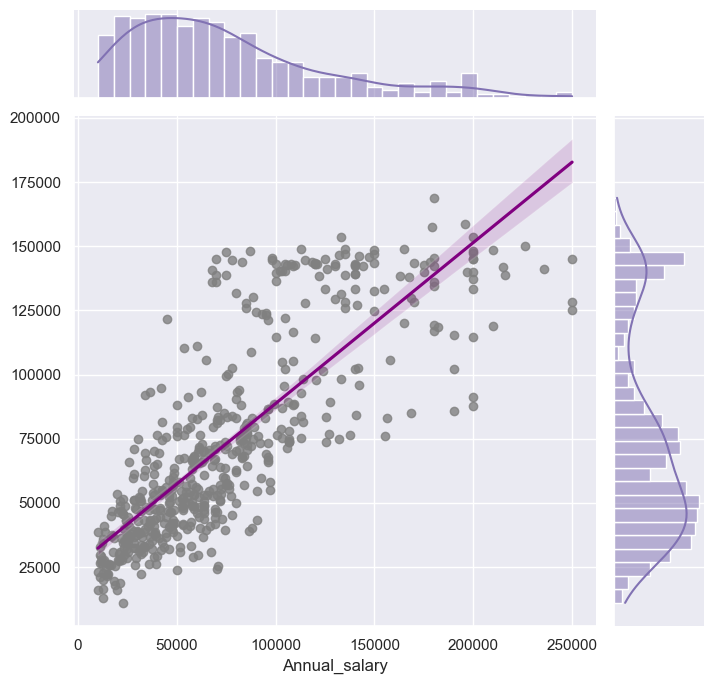

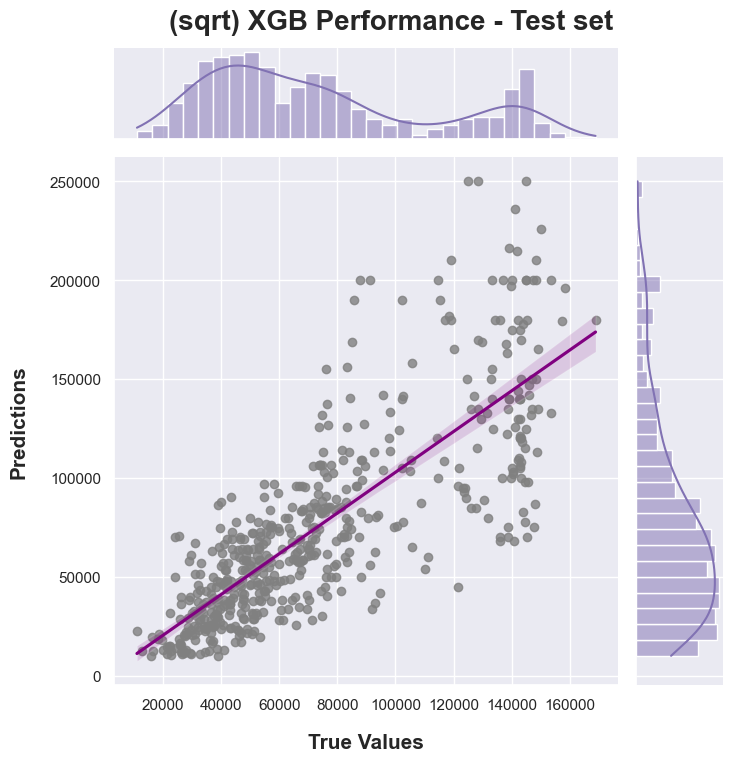

In [27]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)


sns.jointplot(x=y_pred_test, y=np.power(y_test, 2), kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) XGB Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [ ]:
df_cv_results.to_csv("../../output/sqrt-xgb-cv-results.csv")

In [ ]:
y_pred_train.shape, y_pred_test.shape

((2248,), (552,))

Saving train and test sets predictions

In [ ]:
np.savetxt("../../output/sqrt-xgb-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-xgb-test-predictions.csv", y_pred_test, delimiter=",")

## 7. Others

For XGB, let's also see the feature importance

### 7.1. Gain

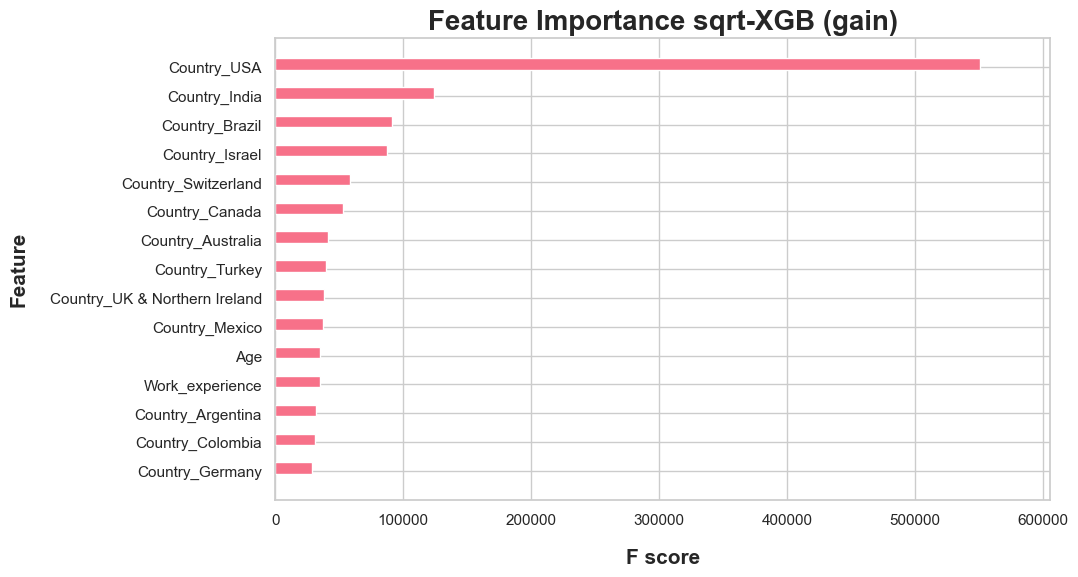

In [ ]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='gain', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance sqrt-XGB (gain)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb-test-fscore-gain.pdf")
plt.show()

### 7.2. Weight

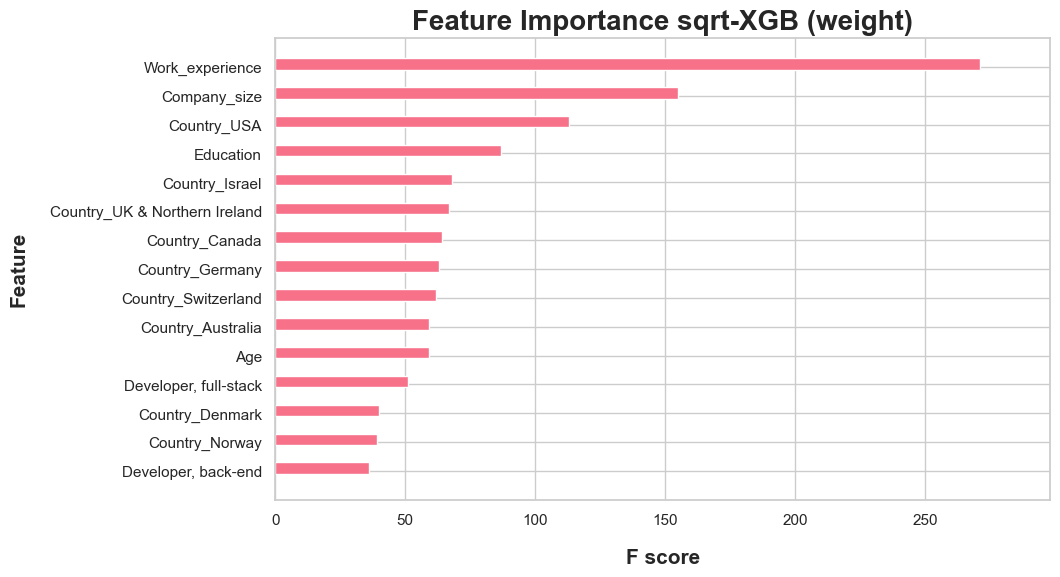

In [ ]:
sns.set_theme(style='whitegrid', palette='husl') 

fig, ax = plt.subplots(figsize=(10, 6))

xgb.plot_importance(clf.best_estimator_, importance_type='weight', max_num_features=15, ax=ax, title='Gain Importance', show_values=False)

for bar in ax.patches:
    bar.set_height(bar.get_height() * 2)  # Multiplica el grosor de las barras por 2

# Ajusta los títulos y etiquetas
ax.set_title('Feature Importance sqrt-XGB (weight)', weight='bold', fontsize=20)
ax.set_xlabel('F score', weight='bold', labelpad=15, fontsize=15)
ax.set_ylabel('Feature', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-xgb-test-fscore-weight.pdf")

plt.show()


In [ ]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2','mean_train_rmse', 'mean_test_rmse']]

,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'colsample_bytree': 0.6247240713084175, 'gamma': 1.9014286128198323, 'learning_rate': 0.0831993941811405, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 714, 'subsample': 0.6674996517121548}",0.651058,0.621595,29701.311045,30881.656902
1,"{'colsample_bytree': 0.45998494949080176, 'gamma': 0.9184977839317343, 'learning_rate': 0.04337086111390219, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 408, 'subsample': 0.9819459112971965}",0.687680,0.624537,28099.963788,30758.090472
2,"{'colsample_bytree': 0.899465584480253, 'gamma': 0.4246782213565523, 'learning_rate': 0.028182496720710062, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 559, 'subsample': 0.7669918962929685}",0.587931,0.577483,32276.520035,32631.743691
3,"{'colsample_bytree': 0.40423978313183045, 'gamma': 0.046124850082831514, 'learning_rate': 0.06247746602583892, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 575, 'subsample': 0.9842533113048755}",0.723873,0.626523,26420.999310,30679.063711
4,"{'colsample_bytree': 0.5396628042581826, 'gamma': 0.1812128690656416, 'learning_rate': 0.07183860093330872, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 931, 'subsample': 0.680057735948788}",0.785964,0.615392,23261.828938,31141.944316
5,"{'colsample_bytree': 0.9159642440417923, 'gamma': 1.3606150771755594, 'learning_rate': 0.05504992519695431, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 700, 'subsample': 0.9793792198447356}",0.684667,0.627236,28234.195753,30649.579389
6,"{'colsample_bytree': 0.8850384088698766, 'gamma': 0.6092275383467414, 'learning_rate': 0.01976721140063839, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 554, 'subsample': 0.7659979946695725}",0.671882,0.617045,28801.078179,31065.408421
7,"{'colsample_bytree': 0.8999169470416986, 'gamma': 0.34672930701554416, 'learning_rate': 0.049106060757324085, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 487, 'subsample': 0.5870266456536466}",0.675231,0.622275,28654.026672,30850.245771
8,"{'colsample_bytree': 0.7120408127066865, 'gamma': 1.0934205586865593, 'learning_rate': 0.028485445552552703, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 829, 'subsample': 0.6698524800218595}",0.717515,0.627245,26723.946280,30650.286482
9,"{'colsample_bytree': 0.6370901416010887, 'gamma': 1.8533177315875884, 'learning_rate': 0.08272719958564209, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 561, 'subsample': 0.5175897174514872}",0.758971,0.619423,24685.442818,30973.482191


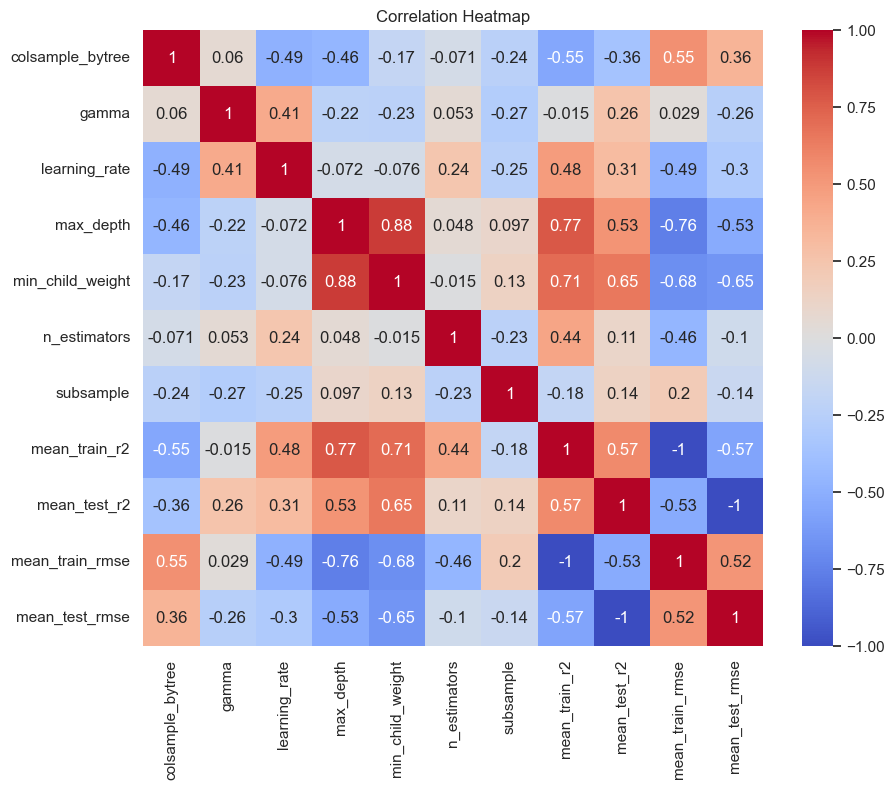

In [ ]:
df_subset = df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

# Extraer las características de la columna 'params' en columnas individuales
params_df = df_subset['params'].apply(pd.Series)
df_processed = pd.concat([params_df, df_subset[['mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]], axis=1)

# Convertir valores de 'bootstrap' a números
# df_processed['bootstrap'] = df_processed['bootstrap'].astype(int)

# Calcular la correlación de Pearson
corr = df_processed.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
corr

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,subsample,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
colsample_bytree,1.000000,0.059796,-0.485996,-0.458433,-0.174017,-0.071164,-0.236424,-0.547056,-0.360117,0.545165,0.357668
gamma,0.059796,1.000000,0.412012,-0.220578,-0.228409,0.053024,-0.273632,-0.015405,0.257014,0.029269,-0.256826
learning_rate,-0.485996,0.412012,1.000000,-0.071705,-0.075666,0.240567,-0.245780,0.484494,0.307296,-0.491383,-0.301974
max_depth,-0.458433,-0.220578,-0.071705,1.000000,0.875000,0.047593,0.096967,0.774606,0.530850,-0.758656,-0.527386
min_child_weight,-0.174017,-0.228409,-0.075666,0.875000,1.000000,-0.015480,0.132883,0.706193,0.653442,-0.680548,-0.651861
n_estimators,-0.071164,0.053024,0.240567,0.047593,-0.015480,1.000000,-0.226994,0.437551,0.109181,-0.455988,-0.103813
subsample,-0.236424,-0.273632,-0.245780,0.096967,0.132883,-0.226994,1.000000,-0.182733,0.135268,0.199819,-0.141402
mean_train_r2,-0.547056,-0.015405,0.484494,0.774606,0.706193,0.437551,-0.182733,1.000000,0.574840,-0.998384,-0.567780
mean_test_r2,-0.360117,0.257014,0.307296,0.530850,0.653442,0.109181,0.135268,0.574840,1.000000,-0.529589,-0.999932
mean_train_rmse,0.545165,0.029269,-0.491383,-0.758656,-0.680548,-0.455988,0.199819,-0.998384,-0.529589,1.000000,0.522218
